In [16]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [17]:
# 1. Load and preprocess data
df = pd.read_csv('data/heart.csv') X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [18]:
# 2. Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test.values)

class HeartDiseaseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HeartDiseaseDataset(X_train_tensor, y_train_tensor)
test_dataset = HeartDiseaseDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [19]:
# 3. Define model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output(x)
        return x

model = SimpleNN(X_processed.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
# 4. Train model with loss tracking
epochs = 50
train_losses = []  # Initialize list to store losses

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)  # Store loss for this epoch
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/50, Loss: 0.6580
Epoch 2/50, Loss: 0.5444
Epoch 3/50, Loss: 0.4165
Epoch 4/50, Loss: 0.3562
Epoch 5/50, Loss: 0.3325
Epoch 6/50, Loss: 0.3157
Epoch 7/50, Loss: 0.3079
Epoch 8/50, Loss: 0.3038
Epoch 9/50, Loss: 0.2984
Epoch 10/50, Loss: 0.2932
Epoch 11/50, Loss: 0.2880
Epoch 12/50, Loss: 0.2859
Epoch 13/50, Loss: 0.2798
Epoch 14/50, Loss: 0.2734
Epoch 15/50, Loss: 0.2724
Epoch 16/50, Loss: 0.2695
Epoch 17/50, Loss: 0.2648
Epoch 18/50, Loss: 0.2598
Epoch 19/50, Loss: 0.2550
Epoch 20/50, Loss: 0.2532
Epoch 21/50, Loss: 0.2476
Epoch 22/50, Loss: 0.2451
Epoch 23/50, Loss: 0.2399
Epoch 24/50, Loss: 0.2379
Epoch 25/50, Loss: 0.2321
Epoch 26/50, Loss: 0.2308
Epoch 27/50, Loss: 0.2269
Epoch 28/50, Loss: 0.2208
Epoch 29/50, Loss: 0.2213
Epoch 30/50, Loss: 0.2153
Epoch 31/50, Loss: 0.2135
Epoch 32/50, Loss: 0.2097
Epoch 33/50, Loss: 0.2059
Epoch 34/50, Loss: 0.2019
Epoch 35/50, Loss: 0.2018
Epoch 36/50, Loss: 0.1964
Epoch 37/50, Loss: 0.1917
Epoch 38/50, Loss: 0.1895
Epoch 39/50, Loss: 0.

In [21]:
# 5. Evaluate model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 90.22%


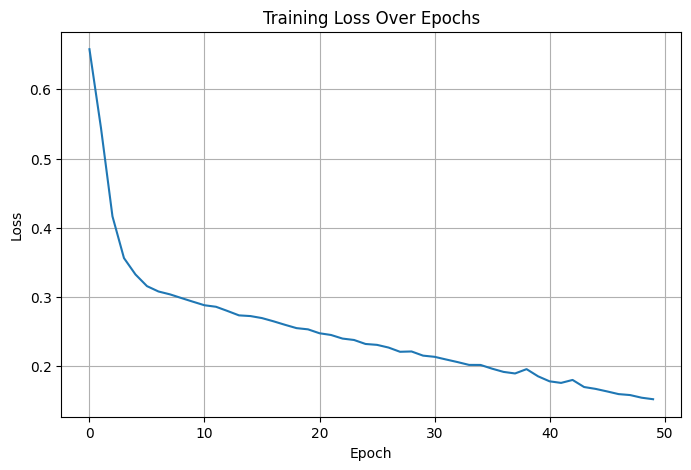

In [ ]:
# 6. Plot training loss::
plt.figure(figsize=(8, 5))
plt.plot(train_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()